In [388]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
Bernoulli = tf.contrib.distributions.Bernoulli

data = input_data.read_data_sets("MNIST_data/", one_hot=True).test
data.images[data.images>0.5] = 1.0
data.images[data.images<=0.5] = 0.0

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz



### Utilitiy functions

In [389]:
def plot_banded_error(errs, label, ax=None):
    ax = ax or plt
    m = np.mean(errs, axis=0)
    s = np.std(errs, axis=0)
    line, = ax.plot(np.arange(1, len(m)+1), m, '.-', label=label)

def fatlegend(ax, *a, **kw):
    leg = ax.legend(*a, **kw)
    for l in leg.legendHandles:
        l.set_linewidth(l.get_linewidth()*2.0)
    return leg

def add_layer(inputs, wn, bn, in_dim, out_dim, af=None):
    try:
        w = tf.get_variable(wn, [in_dim, out_dim], initializer=tf.truncated_normal_initializer)
        b = tf.get_variable(bn, [1, out_dim], initializer=tf.truncated_normal_initializer)
    except:
        with tf.variable_scope(tf.get_variable_scope(), reuse=True):
            w = tf.get_variable(wn)
            b = tf.get_variable(bn)
    return tf.matmul(inputs, w) + b if af is None else af(tf.matmul(inputs, w) + b)

def get_weights(wn, bn):
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        w = tf.get_variable(wn)
        b = tf.get_variable(bn)
    return [w,b]

prob = lambda p, s: s*p+(1.0-s)*(1.0-p)
log_prob = lambda p, s: tf.log(tf.clip_by_value(prob(p, s), eps, 1.0-eps))

def det_pass(inputs, layer, n, _expect):
    if layer==1:
        inputs = add_layer(inputs, "whh", "bhh", nh, nh, tf.nn.sigmoid)
    z = prob(add_layer(inputs, "why", "bhy", nh, 392, tf.nn.sigmoid), tf.tile(y_,[n,1]))
    return tf.reduce_sum(z/tf.stop_gradient(tf.tile(-_expect-eps,[n,1])), 1, keep_dims=True)

def stc_pass(inputs, layer, n):
    if layer==1:
        z = add_layer(inputs, "whh", "bhh", nh, nh, tf.nn.sigmoid)
        inputs = tf.reshape(Bernoulli(probs=z,dtype=tf.float32).sample(n), [n*n*batch_size,nh])
    z = add_layer(inputs, "why", "bhy", nh, 392, tf.nn.sigmoid)
    z = tf.reduce_mean(tf.reshape(z,[n,n*batch_size,392]), 0) if layer==1 else z
    z = prob(z, tf.tile(y_,[n,1]))
    z_expect = tf.reduce_mean(tf.reshape(z, [n,batch_size,392]), 0)
    return tf.reduce_sum(z/tf.stop_gradient(tf.tile(-z_expect-eps, [n,1])), 1, keep_dims=True), z_expect

def fg_cov(f, g, w, n):
    f, g = [tf.reshape(z, [n,batch_size,nh]) for z in [f,g]]
    for i in range(n):
        df, dg = [tf.concat(tf.gradients(tf.reduce_mean(z[i], 0), w), 0) for z in [f, g]]
        mf, mg = [df, dg] if i==0 else [mf+df, mg+dg]
        vg = tf.square(dg) if i==0 else vg+tf.square(dg)
        cov = df*dg if i==0 else cov+df*dg
    return mf/n, mg/n, (cov-mf*mg/n)/(n-1), (vg-tf.square(mg)/n)/(n-1)

def check_rand():
    s = tf.sqrt(tf.reduce_mean(tf.square(h-.5)))
    r = tf.reduce_sum(tf.cast(h>.5+s, tf.float32))+tf.reduce_sum(tf.cast(h<.5-s, tf.float32))
    s2 = tf.sqrt(tf.reduce_mean(tf.square(h2-.5)))
    r2 = tf.reduce_sum(tf.cast(h2>.5+s2, tf.float32))+tf.reduce_sum(tf.cast(h2<.5-s2, tf.float32))
    return (r+r2)/tf.reduce_sum(tf.shape(h)+tf.shape(h2))
    
def gd_stats(p, s, f, g, mg, dh, w):
    mdf, mdg = [tf.concat(tf.gradients(tf.reduce_mean(z,0), w), 0) for z in [f, g]]
    mgd = tf.concat([dh[0][0], dh[1][0]], 0)
    
    f, g, s = [tf.reshape(z, [ns, batch_size, nh]) for z in [f, g, s]]
    for i in range(ns):
        df, dg = [tf.concat(tf.gradients(tf.reduce_mean(z, 0), w), 0) for z in [f[i], g[i]]]
        vf = tf.square(df-mdf) if i==0 else vf+tf.square(df-mdf)
        vg = tf.square(dg-mdg) if i==0 else vg+tf.square(dg-mdg)        
        cov = (df-mdf)*(dg-mdg) if i==0 else cov+(df-mdf)*(dg-mdg)
        gd = tf.concat(tf.gradients(tf.reduce_mean(f[i]-g[i]+mg, 0), w), 0)
        vgd = tf.square(gd-mgd) if i==0 else vgd+tf.square(gd-mgd)    
    vf, vg, cov, vgd = [tf.reduce_sum(z)/(ns-1) for z in [vf, vg, cov, vgd]]
    return vf+vg-2*cov, vgd

### Parameters

In [390]:
batch_size = 4
lr = 1e-3
eps = 1e-7
alpha = 0.9
nh = 100

### Graph

In [391]:
ns = tf.placeholder(tf.int32)

x   = tf.placeholder(tf.float32, [None, 392])
h   = add_layer(x, "wxh", "bxh", 392, 100, tf.nn.sigmoid)
sh  = tf.stop_gradient(tf.reshape(Bernoulli(probs=h, dtype=tf.float32).sample(ns), [-1,100]))
h2  = add_layer(sh, "whh", "bhh", 100, 100, tf.nn.sigmoid)
sh2 = tf.stop_gradient(tf.reshape(Bernoulli(probs=h2, dtype=tf.float32).sample(ns), [-1,100]))
y   = add_layer(sh2, "why", "bhy", 100, 392, tf.nn.sigmoid)
y_expect = tf.reduce_mean(tf.reshape(y, [ns**2, -1, 392]), 0)
y_  = tf.placeholder(tf.float32, [None, 392])

nll = tf.reduce_mean(tf.reduce_sum(-log_prob(y_expect, y_), 1))
ls2 = tf.reduce_sum(prob(y, tf.tile(y_,[ns**2,1]))/
                    tf.stop_gradient(tf.tile(-prob(y_expect, y_)-eps, [ns**2,1])), 1, keep_dims=True)
ls  = tf.reduce_mean(tf.reshape(ls2, [ns,-1, 1]), 0)

opt = tf.train.AdamOptimizer(lr)
_h, _h2 = [tf.tile(z, [ns, 1]) for z in [h, h2]]
dy = opt.compute_gradients(nll, get_weights("why", "bhy"))    
dh2 = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(ls2)*log_prob(_h2, sh2), 0), 
                            get_weights("whh", "bhh"))        
dh  = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(ls)*log_prob(_h, sh), 0),
                            get_weights("wxh", "bxh"))
gd = [list(i) for i in dy]+[list(i) for i in dh2]+[list(i) for i in dh]
train_step = opt.apply_gradients(gd)

In [392]:
_why = tf.placeholder(tf.float32,[100, 392])
_bhy = tf.placeholder(tf.float32,[  1, 392])
_whh = tf.placeholder(tf.float32,[100, 100])
_bhh = tf.placeholder(tf.float32,[  1, 100])
_wxh = tf.placeholder(tf.float32,[392, 100])
_bxh = tf.placeholder(tf.float32,[  1, 100])

gd_why = tf.placeholder(tf.float32,[100, 392])
gd_bhy = tf.placeholder(tf.float32,[  1, 392])
gd_whh = tf.placeholder(tf.float32,[100, 100])
gd_bhh = tf.placeholder(tf.float32,[  1, 100])
gd_wxh = tf.placeholder(tf.float32,[392, 100])
gd_bxh = tf.placeholder(tf.float32,[  1, 100])

lh  = tf.nn.sigmoid(tf.matmul(x,_wxh)+_bxh)
lh2 = tf.nn.sigmoid(tf.matmul(sh,_whh)+_bhh)
ly  = tf.nn.sigmoid(tf.matmul(sh2,_why)+_bhy)
ly_expect = tf.reduce_mean(tf.reshape(ly, [ns**2, -1, 392]), 0)

lnll = tf.reduce_mean(tf.reduce_sum(-log_prob(ly_expect, y_), 1))
lls2 = tf.reduce_sum(prob(ly, tf.tile(y_,[ns**2,1]))/
                     tf.stop_gradient(tf.tile(-prob(ly_expect, y_)-eps, [ns**2,1])), 1, keep_dims=True)
lls = tf.reduce_mean(tf.reshape(lls2, [ns,-1,1]), 0)
_lh, _lh2 = [tf.tile(z, [ns, 1]) for z in [lh, lh2]]

dly  = tf.gradients(lnll, [_why, _bhy])    
dlh2 = tf.gradients(tf.reduce_mean(tf.stop_gradient(lls2)*log_prob(_lh2, sh2), 0), [_whh, _bhh])        
dlh  = tf.gradients(tf.reduce_mean(tf.stop_gradient(lls)*log_prob(_lh, sh), 0), [_wxh, _bxh])

ggd = [list(i) for i in dy]+[list(i) for i in dh2]+[list(i) for i in dh]
ggd[0][0] -= dly[0]  - gd_why
ggd[1][0] -= dly[1]  - gd_bhy
ggd[2][0] -= dlh2[0] - gd_whh
ggd[3][0] -= dlh2[1] - gd_bhh
ggd[4][0] -= dlh[0]  - gd_wxh
ggd[5][0] -= dlh[1]  - gd_bxh
gtrain_step = opt.apply_gradients(ggd)

cgd = [list(i) for i in dy]+[list(i) for i in dh2]+[list(i) for i in dh]
cgd[0][0] -= dly[0]  - gd_why
cgd[1][0] -= dly[1]  - gd_bhy
cgd[2][0] -= dlh2[0] - gd_whh
cgd[3][0] -= dlh2[1] - gd_bhh
cgd[4][0] -= dlh[0]  - gd_wxh
cgd[5][0] -= dlh[1]  - gd_bxh
for i in range(6):
    cgd[i][0] *= Bernoulli(probs=0.33*tf.ones(tf.shape(cgd[i][0])), dtype=tf.float32).sample()
ctrain_step = opt.apply_gradients(cgd)

### Train

In [403]:
steps=50000

with tf.Session() as sess:
    loss_rec = np.empty((1000, steps/1000))
    sess.run(tf.global_variables_initializer())

    for i in range(steps):
        if i%10==0:
            batch_   = data.next_batch(40, shuffle=True)[0]
            batch_xs = batch_[:, 0:392]
            batch_ys = batch_[:, 392:784]
            res = sess.run([train_step, gd, nll], {x: batch_xs, y_: batch_ys, ns: 10})
            w1, gdw1 = res[1][0][1], res[1][0][0]
            w2, gdw2 = res[1][1][1], res[1][1][0]
            w3, gdw3 = res[1][2][1], res[1][2][0]
            w4, gdw4 = res[1][3][1], res[1][3][0]
            w5, gdw5 = res[1][4][1], res[1][4][0]
            w6, gdw6 = res[1][5][1], res[1][5][0]
        else:
            batch_   = data.next_batch(6, shuffle=True)[0]
            batch_xs = batch_[:, 0:392]
            batch_ys = batch_[:, 392:784]        
            res = sess.run([ctrain_step, nll],
                           {x: batch_xs, y_: batch_ys, ns: 2,
                              _why:   w1,   _bhy:   w2,   _whh:   w3,   _bhh:   w4,   _wxh:   w5,   _bxh:   w6,
                            gd_why: gdw1, gd_bhy: gdw2, gd_whh: gdw3, gd_bhh: gdw4, gd_wxh: gdw5, gd_bxh: gdw6})        
        
#        batch = np.random.permutation(batch_)
#        batch_xs = batch[0:6, 0:392]
#        batch_ys = batch[0:6, 392:784]

        
        loss_rec[i%1000, i/1000] = res[-1]
        if (i+1)%1000==0:
            print (i+1)/1000, np.mean(loss_rec[:, i/1000], 0),
            
cd_svrg = loss_rec
#np.save("dn_20_4.npy", dn_20_4)

 1 225.926526276 2 135.673747849 3 126.780084488 4 120.968145882 5 116.867987572 6 115.325392464 7 113.104141388 8 111.599080544 9 110.142886337 10 108.943556755 11 107.825503277 12 106.702440758 13 107.779146774 14 105.675172558 15 106.55701609 16 104.972742485 17 104.21350565 18 103.451949776 19 103.246841263 20 103.392802784 21 102.089227257 22 102.639917873 23 102.124045891 24 102.193623474 25 101.631833393 26 101.700996487 27 101.991906544 28 100.947761932 29 100.500131413 30 100.772483414 31 100.328130829 32 99.159036026 33 99.5896619377 34 98.8068266754 35 98.5152336159 36 99.3008350945 37 97.9770104561 38 98.022461174 39 98.809205555 40 98.5254059448 41 97.8895234489 42 97.4572523651 43 96.4631414375 44 97.5139991875 45 97.4655518494 46 97.0523256989 47 95.7825054626 48 95.8927487221 49 95.8382596397 50 96.1415304337


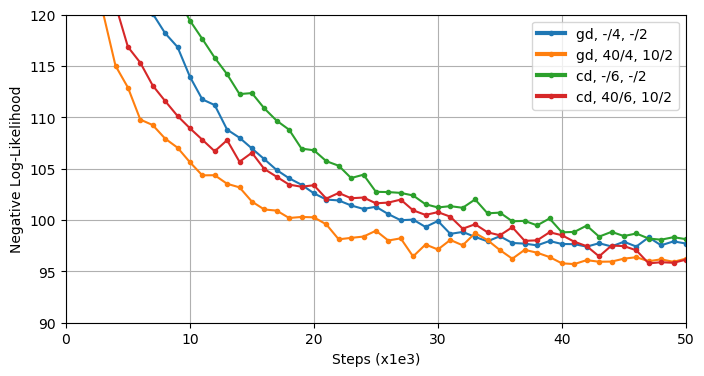

In [405]:
#saver = tf.train.Saver()

plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(8,4))
plt.xlim(0,50)
plt.ylim(90,120)

plot_banded_error(lhr, "gd, -/4, -/2")
plot_banded_error(gd_svrg, "gd, 40/4, 10/2")
plot_banded_error(cd, "cd, -/6, -/2")
plot_banded_error(cd_svrg, "cd, 40/6, 10/2")

fatlegend(ax)
plt.ylabel("Negative Log-Likelihood")
plt.xlabel("Steps (x1e3)")
ax.grid(True)
plt.show()
#fig.savefig('lhr_cd.png')

In [305]:
steps = 100000
with tf.Session() as sess:
    loss_rec = np.empty((1000, steps/1000))
    sess.run(tf.global_variables_initializer())

    for i in range(steps):
        if i%10==0:
            batch_   = data.next_batch(40, shuffle=True)[0]
            batch_xs = batch_[:, 0:392]
            batch_ys = batch_[:, 392:784]
            
            res = sess.run(mgd, {x: batch_xs, y_: batch_ys})
            w1, gdw1 = res[0][1], res[0][0]
            w2, gdw2 = res[1][1], res[1][0]
            w3, gdw3 = res[2][1], res[2][0]
            w4, gdw4 = res[3][1], res[3][0]
            w5, gdw5 = res[4][1], res[4][0]
            w6, gdw6 = res[5][1], res[5][0]


        if i%10==0 or i%10==3 or i%10==6:
            batch_   = data.next_batch(6, shuffle=True)[0]
            batch_xs = batch_[:, 0:392]
            batch_ys = batch_[:, 392:784]            
            res = sess.run(ggd,
                           {x: batch_xs, y_: batch_ys,
                            _why: w1, _bhy: w2, _whh: w3, _bhh: w4, _wxh: w5, _bxh: w6, 
                            gd_why: gdw1, gd_bhy: gdw2, gd_whh: gdw3, gd_bhh: gdw4, gd_wxh: gdw5, gd_bxh: gdw6
                           })
            _w1, _gdw1 = res[0][1], res[0][0]
            _w2, _gdw2 = res[1][1], res[1][0]
            _w3, _gdw3 = res[2][1], res[2][0]
            _w4, _gdw4 = res[3][1], res[3][0]
            _w5, _gdw5 = res[4][1], res[4][0]
            _w6, _gdw6 = res[5][1], res[5][0]   
         


        res = sess.run([ctrain_step, nll],
                       {x: batch_xs, y_: batch_ys,
                        _why: _w1, _bhy: _w2, _whh: _w3, _bhh: _w4, _wxh: _w5, _bxh: _w6,
                        gd_why: _gdw1, gd_bhy: _gdw2, gd_whh: _gdw3, gd_bhh: _gdw4, gd_wxh: _gdw5, gd_bxh: _gdw6
                       })            
                    
        loss_rec[i%1000, i/1000] = res[-1]
        if (i+1)%1000==0:
            print (i+1)/1000, np.mean(loss_rec[:, i/1000], 0),
            
lhr_c_2_level = loss_rec
#np.save("dn_20_4.npy", dn_20_4)

 1 239.942942177 2 144.722213524 3 133.083482224 4 128.604465164 5 121.664365952 6 120.757792709 7 115.411777779 8 115.511042488 9 113.362022095 10 112.442968796 11 109.598084854 12 109.190522488 13 108.739118073 14 108.005430168 15 105.758023907 16 107.680377968 17 107.191055256 18 104.723335342 19 106.549087788 20 105.569339828 21 103.040910671 22 102.826203472 23 103.532092747 24 102.165117702 25 102.928911018 26 101.075300465 27 102.15869318 28 100.961011791 29 100.539067112 30 100.896955666 31 100.069237732 32 100.186051434 33 101.301381603 34 101.033304596 35 99.7741466599 36 99.4336634293 37 99.0933897667 38 99.6782082901 39 98.672123455 40 97.1339963951 41 98.0019806786 42 96.9894972916 43 99.1230604477 44 97.9279421425 45 98.8240501366 46 98.1516211433 47 98.0497722054 48 97.1405198822 49 97.861278759 50 97.5131786041 51 97.5407901726 52 97.6144888763 53 96.9263190689 54 97.4755410805 55 97.1902096977 56 97.395585556 57 97.6835475616 58 97.1872554588 59 95.9386793823 60 98.239

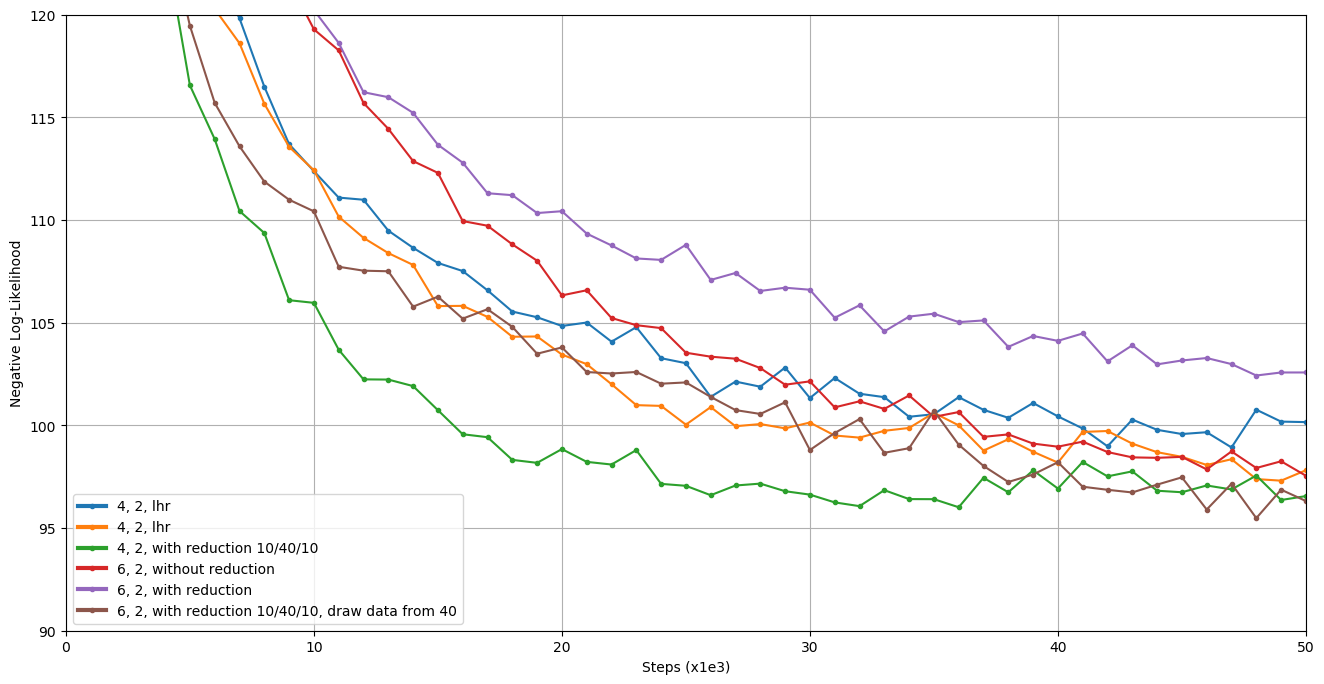

In [326]:
#saver = tf.train.Saver()

plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(16,8))
plt.xlim(0,50)
plt.ylim(90,120)


plot_banded_error(lhr, "4, 2, lhr")
plot_banded_error(lhr_4_same, "4, 2, lhr")
#plot_banded_error(lhr_same, "4, 2, lhr, draw data from 40")
plot_banded_error(lhr_g_rd, "4, 2, with reduction 10/40/10") # SVRG
plot_banded_error(lhr_c, "6, 2, without reduction") # coordinate
plot_banded_error(lhr_c_6_same, "6, 2, with reduction") # coordinate

#plot_banded_error(lhr_c_same, "6, 2, without reduction, same") #coordinate, draw 6 from 40, update 40 every 10 step
#plot_banded_error(lhr_c_rd, "6, 2, with reduction 10/40/10")
plot_banded_error(lhr_c_rd_same, "6, 2, with reduction 10/40/10, draw data from 40")

#plot_banded_error(lhr_c_2_level, "6, 2, with reduction 10/40/10, same") # 40/10 - 6/10 - 6/2


#plot_banded_error(lhr_c2, "40/40, 10/2, loop = 0")
#plot_banded_error(lhr_c3, "40/-, 10/2, inner loop = 0")
#plot_banded_error(lhr_g, "40/4, 10/2, g")
#plot_banded_error(cd_qq, "40/4, 10/2, 2level")


fatlegend(ax)
plt.ylabel("Negative Log-Likelihood")
plt.xlabel("Steps (x1e3)")
ax.grid(True)
plt.show()
#fig.savefig('lhr_cd.png')

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
up = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[2]]], 1)
dw = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[3]]], 1)
p1 = np.concatenate(np.split(np.concatenate([up,dw], 0), batch_size/10, 1), 0)
dwy = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[4]]], 1)
p2 = np.concatenate(np.split(np.concatenate([up,dwy], 0), batch_size/10, 1), 0)
ax[0].imshow(p1, cmap=plt.cm.gray, interpolation='none')
ax[1].imshow(p2, cmap=plt.cm.gray, interpolation='none')
ax[0].grid(False)
ax[1].grid(False)
plt.show()

### backup

In [128]:
bsln = tf.placeholder(tf.float32)
bslnv = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(lr)

def gd_est(md, linear, cf, sta, nn):
    func = {
        0: lambda p, s, layer, w, cf, nn: [tf.zeros([ns**layer*batch_size,1]), tf.zeros([1])],
        1: muProp,
        2: DARN,
        3: baseline,
        4: NVIL
    }
    g2, mg2 = func.get(md)(h2, sh2, 2, get_weights("whh", "bhh"), cf, nn)
    g, mg = func.get(md)(h, sh, 1, get_weights("wxh", "bxh"), cf, nn)
    f, f2 = ls, ls2
    m = g2
    v = tf.constant(0.)
    tr = None
    
    dy = opt.compute_gradients(nll, get_weights("why", "bhy"))    
    if linear:
        c2 = cv_coef(h2, nn, 2, get_weights("whh", "bhh")) if cf else tf.ones([batch_size*ns,1])        
        c = cv_coef(h, nn, 1, get_weights("wxh", "bxh")) if cf else tf.ones([batch_size,1])   
        dh2 = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f2-tf.tile(c2,[ns,1])*g2)*log_prob(_h2, sh2), 0)+
                                    tf.reduce_mean(tf.stop_gradient(c2)*mg2, 0), get_weights("whh", "bhh"))        
        dh  = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f-tf.tile(c,[ns,1])*g)*log_prob(_h, sh), 0)+
                                    tf.reduce_mean(tf.stop_gradient(c)*mg, 0), get_weights("wxh", "bxh"))
    else:
        dh2f, dh2g, dh2mg = [opt.compute_gradients(tf.reduce_mean(z, 0), get_weights("whh", "bhh"))
                             for z in [tf.stop_gradient(f2)*log_prob(_h2, sh2),
                                       tf.stop_gradient(g2)*log_prob(_h2, sh2), mg2]]
        dhf, dhg, dhmg = [opt.compute_gradients(tf.reduce_mean(z, 0), get_weights("wxh", "bxh"))
                          for z in [tf.stop_gradient(f)*log_prob(_h, sh),
                                    tf.stop_gradient(g)*log_prob(_h, sh), mg]]
        if cf:
            b2 = bias_cor(f2, g2, _h2, sh2, nn, 2, get_weights("whh", "bhh"), nh) 
            b = bias_cor(f, g, _h, sh, nn, 1, get_weights("wxh", "bxh"), 392)
        else:
            b2 = [tf.zeros([nh,nh]), tf.zeros([1,nh])]
            b = [tf.zeros([392,nh]), tf.zeros([1,nh])]
        
        dh2, dh = [list(z) for z in dh2f], [list(z) for z in dhf]
        for j in range(2):
            dh2[j][0] = (dh2[j][0]/(dh2g[j][0]+eps)-b2[j])*dh2mg[j][0]
            dh[j][0] = (dh[j][0]/(dhg[j][0]+eps)-b[j])*dhmg[j][0]

    gd = [list(i) for i in dy]+[list(i) for i in dh2]+[list(i) for i in dh]

    train_step = opt.apply_gradients(gd if tr is None else gd+tr)
    return train_step, y_expect, nll, m, v

def muProp(p, s, layer, w, cf, nn):
    fh = det_pass(p, layer, ns**(layer-1), prob(y_expect, y_))
    dfh = tf.gradients(fh, p)[0]
    mg = tf.stop_gradient(dfh)*p
    fh, dfh, p = [tf.tile(z, [ns,1]) for z in [fh, dfh, p]]
    g = fh+tf.reduce_sum(dfh*(s-p), 1, keep_dims=True)
    return g, mg

def cv_coef(p, nn, layer, w):
    p = tf.reshape(p, [ns**(layer-1), batch_size, nh])
    for i in range(ns**(layer-1)):
        pp = p[i]
        ss = tf.stop_gradient(tf.reshape(Bernoulli(probs=pp, dtype=tf.float32).sample(nn), 
                                         [nn*batch_size, nh]))
        sls, sls_expect = stc_pass(ss, layer, nn)
        fh = det_pass(pp, layer, 1, sls_expect)
        dfh = tf.gradients(fh, pp)[0]
        _fh, _dfh, _p = [tf.tile(z, [nn,1]) for z in [fh, dfh, pp]]
        f = tf.stop_gradient(sls)*log_prob(_p, ss)
        g = tf.stop_gradient(_fh+tf.reduce_sum(_dfh*(ss-_p), 1, keep_dims=True))*log_prob(_p, ss)
        _, _, cov, vg = fg_cov(f, g, w, nn)
        t = tf.tile([[tf.reduce_sum(cov)/(tf.reduce_sum(vg)+eps)]],[batch_size,1])
        coef = t if i==0 else tf.concat([coef, t], 0)
    return coef

def bias_cor(f, g, p, s, nn, layer, w, dim):
    ff, gg = [tf.stop_gradient(z)*log_prob(s, p) for z in [f,g]]
    _f, _g = [tf.reshape(z,[ns,ns**(layer-1)*batch_size,nh]) for z in [ff,gg]]
    for i in range(ns):
        df, dg = [tf.concat(tf.gradients(z[i], w), 0) for z in [_f, _g]]
        mfg, mg = [df/(dg+eps), dg] if i==0 else [mfg+df/(dg+eps), mg+dg]
        sfgg = df if i==0 else sfgg+df
    mg /= ns
    sfgg = (sfgg-mg*mfg)/(ns-1)
    b = sfgg/(mg+eps)
    return b[0:dim], b[dim]

def DARN(p, s, layer, w, cf, nn):
    # only work for one layer
    if layer==1:
        return muProp(p, s, layer, w, cf, nn)
    dh = tf.gradients(ls2, s)[0] 
    g = ls2 + dh*(.5-s)
    return g, tf.zeros([1])

def baseline(p, s, layer, w, cf, nn):
    b = alpha*bsln + (1.0-alpha)*tf.reduce_mean(ls)
    g = tf.stop_gradient(b)
    return g, tf.zeros([1])

def NVIL():
    ch = add_layer(x, "wh", "bh", 392, 100, tf.tanh)
    cy = add_layer(ch, "wy", "by", 100, 1)
    b = alpha*bsln + tf.reduce_mean((1.0-alpha)*(loss-cy))
    vv = tf.reduce_mean(tf.square(loss-cy-tf.reduce_mean(loss-cy)))/tf.maximum(1.0, (ns-1))
    v = alpha*bslnv + (1.0-alpha)*vv
    g = tf.stop_gradient((cy+b)/tf.maximum(1.0,tf.sqrt(v))) * p
    f = tf.stop_gradient(loss/tf.maximum(1.0,tf.sqrt(v))) * p
    tr = opt.compute_gradients(tf.reduce_mean(tf.square(tf.stop_gradient(loss-b)-cy)), 
                               [get_weights("wh", "bh", 392, 100), get_weights("wy", "by", 100, 1)])
    return f, g, None, tr, b, v

def ST_():
    train_step = tf.train.AdamOptimizer(lr).minimize(nll)
    return train_step, nll, tf.constant(0.), tf.constant(0.)